# Movie Reviews Dataset
* Input patterns: movie reviews in natural language.
* Labels: sentiment analysis of the text
    * Classes: *negative, positive*
* Ground truth: What the person thought when writing the review
* Annotations: re-collected from Amazon Mechanical Turk (AMT).
    * Number of annotators (T) = 203  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    
np.set_printoptions(precision=4, suppress=True)

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder = "./data/Sentiment/"

### Load Data and preprocess

In [4]:
from codeE.utils import read_texts
texts_train = read_texts(folder+"Sentiment_text_train.txt")
texts_test  = read_texts(folder+"Sentiment_text_test.txt")

Z_train = np.loadtxt(folder+"Sentiment_Z_train.txt", dtype='int')
Z_test  = np.loadtxt(folder+"Sentiment_Z_test.txt", dtype='int')

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 4999
Num. test texts:  3999


In [5]:
from keras import preprocessing
MAX_NB_WORDS = 14000
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
#MAX_NB_WORDS = len(tokenizer.word_index)
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 14096 unique tokens.


In [6]:
lens = list(map(len,sequences_train))
max_L = np.max(lens)
print("Real max: ",max_L)
max_L = 50 
print("Used max: ",max_L)

X_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_L,dtype='int32', value=0,padding='pre')
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
print('Shape of train tensor:', X_train.shape)

Real max:  51
Used max:  50
Shape of train tensor: (4999, 50)


In [7]:
EMBEDDING_DIM = 300
GLOVE_FILE = "../GLOVE/glove.6B.%dd.txt"%(EMBEDDING_DIM)

embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i < MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))
v=0
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
        v+=1
del embeddings_index, sorted_x, tokenizer
gc.collect()
print("Words found on glove: ",v)

Preparing embedding matrix.
Words found on glove:  12935


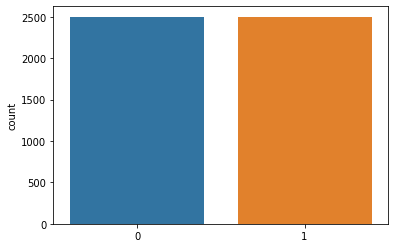

In [8]:
sns.countplot(Z_train)
plt.show()

### Load annotations 

In [8]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1

N,T = y_obs.shape
print("Shape (data,annotators): ",(N,T))
print("Classes: ", np.max(y_obs)+1)

Loading AMT data...
Shape (data,annotators):  (4999, 203)
Classes:  2


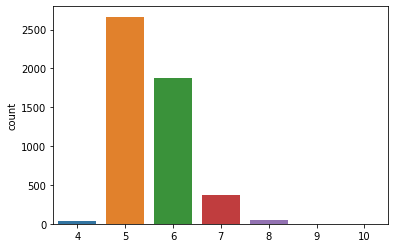

Minimum annotations in a example:  4
Maximum annotations in a example:  10
T data (expected value):  5.550310062012403
Graphics of T weights


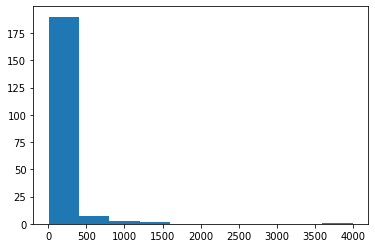

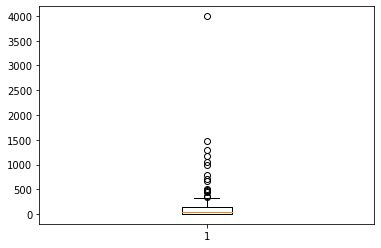

Minimum annotations by an annotator:  5
Maximum annotations by an annotator:  3993
Mean annotations by an annotator:  136.67980295566502


In [10]:
N_ann = np.sum(y_obs != -1,axis=1) 

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

T_weights = np.sum(y_obs != -1,axis=0) #number of annotations per annotator
print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Upper Bound Model -- ideal

In [9]:
#### Delta Convergence criteria
from codeE.learning_models import default_RNN_text, Clonable_Model
from codeE.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

In [10]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_RNN_text(max_L, Z_train_onehot.shape[1], embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
clone_UB = Clonable_Model(model_UB)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Trained IDeal Model, Epochs to converge = 40


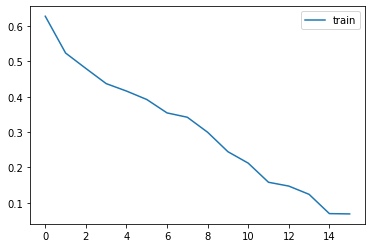

In [13]:
plt.plot(hist.history["loss"],label="train")
plt.legend()

In [14]:
from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(model_UB, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_UB, X_test, Z_test))

Train accuracy of model = 0.991998399679936
Test accuracy of model = 0.7271817954488622


### Generate Matrix representation of both scenarios

In [11]:
from codeE.representation import set_representation

y_obs_categorical = set_representation(y_obs,'onehot') 
print("Individual representation shape (N,T,K)= ",y_obs_categorical.shape)

r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

Individual representation shape (N,T,K)=  (4999, 203, 2)
Global representation shape (N,K)=  (4999, 2)


In [12]:
r_obs

array([[0, 5],
       [5, 0],
       [4, 2],
       ...,
       [2, 4],
       [1, 4],
       [3, 2]], dtype=int32)

### Real Confusion matrices
Generate the individual and global confusion matrices based on the sampled annotations.

In [13]:
from codeE.utils import generate_Individual_conf

conf_matrix_I = generate_Individual_conf(Z_train, y_obs_categorical)
print("Individual matrix shape (T,K,K)= ",conf_matrix_I.shape)
conf_matrix_I

Individual matrix shape (T,K,K)=  (203, 2, 2)


array([[[0.7059, 0.2941],
        [0.3333, 0.6667]],

       [[0.9483, 0.0517],
        [0.1373, 0.8627]],

       [[0.9756, 0.0244],
        [0.1053, 0.8947]],

       [[0.9306, 0.0694],
        [0.0763, 0.9237]],

       [[0.9401, 0.0599],
        [0.2284, 0.7716]],

       [[0.6469, 0.3531],
        [0.1608, 0.8392]],

       [[0.9344, 0.0656],
        [0.0792, 0.9208]],

       [[0.8919, 0.1081],
        [0.1127, 0.8873]],

       [[0.625 , 0.375 ],
        [0.381 , 0.619 ]],

       [[0.8139, 0.1861],
        [0.1332, 0.8668]],

       [[0.8372, 0.1628],
        [0.2289, 0.7711]],

       [[0.8983, 0.1017],
        [0.06  , 0.94  ]],

       [[0.9123, 0.0877],
        [0.1466, 0.8534]],

       [[0.9301, 0.0699],
        [0.1252, 0.8748]],

       [[0.7703, 0.2297],
        [0.1429, 0.8571]],

       [[0.9327, 0.0673],
        [0.1178, 0.8822]],

       [[0.9286, 0.0714],
        [0.0909, 0.9091]],

       [[0.9383, 0.0617],
        [0.0678, 0.9322]],

       [[0.4615, 0.5385],
  

Global matrix shape (K,K)=  (2, 2)


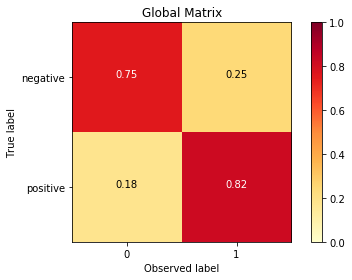

In [14]:
from codeE.utils import generate_Global_conf

#confe_matrix_G = generate_Global_conf(Z_train, y_obs_categorical)
confe_matrix_G = generate_Global_conf(Z_train, r_obs)
print("Global matrix shape (K,K)= ",confe_matrix_G.shape)

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(confe_matrix_G, ["negative", "positive"], title= "Global Matrix")

## Aggregation methods (without predictive model)
* Majority Voting (MV)
* Weighted Majority Voting
* Dawid and Skene (DS): with inference

In [15]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="global")

mv_soft = label_A.infer(  r_obs, 'softMV')
mv_hard = label_A.predict(r_obs, 'hardMV')
mv_hard

array([1, 0, 0, ..., 1, 1, 0])

In [16]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="individual")

mv_soft = label_A.infer(  y_obs_categorical, 'softMV')
mv_hard = label_A.predict(y_obs_categorical, 'hardMV')
mv_soft

array([[0.    , 1.    ],
       [1.    , 0.    ],
       [0.6667, 0.3333],
       ...,
       [0.3333, 0.6667],
       [0.2   , 0.8   ],
       [0.6   , 0.4   ]], dtype=float32)

In [21]:
print("ACC MV on train:",np.mean(mv_hard==Z_train))

ACC MV on train: 0.8895779155831166


### generate confusion matrix to understand MV

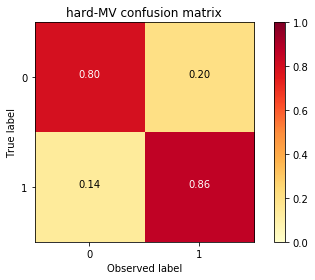

In [24]:
from codeE.utils import generate_confusionM
prob_Yz = generate_confusionM(mv_hard, r_obs) #confusion matrix of all annotators
plot_confusion_matrix(prob_Yz, title= "hard-MV confusion matrix")

### Metrics to compare the estimation of confusion matrix

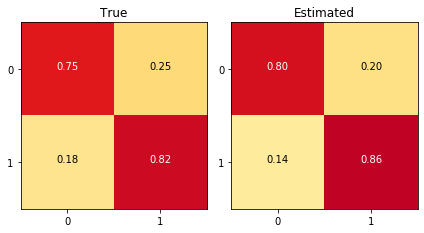

In [26]:
from codeE.utils import compare_conf_ma
compare_conf_ma(prob_Yz, true_conf_mat=confe_matrix_G, text=True)

In [27]:
from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.0018885730640643085
Global D (based on normalized Frobenius) = 0.03987046331167221


##### Weighted

In [28]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="individual")

Wmv_soft = label_A.infer(y_obs_categorical, 'softMV', weights=T_weights)
Wmv_soft

array([[0.    , 1.    ],
       [1.    , 0.    ],
       [0.9575, 0.0425],
       ...,
       [0.4652, 0.5348],
       [0.0954, 0.9046],
       [0.4188, 0.5812]], dtype=float32)

In [29]:
print("ACC MV on train:",np.mean(Wmv_soft.argmax(axis=-1)==Z_train))

ACC MV on train: 0.7631526305261053


### Dawid and Skene model

In [36]:
from codeE.methods import LabelInf_EM as DS

DS_model = DS(init_Z='softmv') 
#DS_model = DS(init_Z='softmv', priors="None", fast=False) 
    
# if you want you can initialize step E forcing some method
#DS_model.init_E(y_obs_categorical)
#DS_model.get_qestimation()

hist = DS_model.fit(y_obs_categorical, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Z marginal shape (2,)
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -14653.156	
Iter 2/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -13799.342	Tol1: 0.05827	Tol2: 0.25907	
Iter 3/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -13743.929	Tol1: 0.00402	Tol2: 0.13517	
Iter 4/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -13734.473	Tol1: 0.00069	Tol2: 0.09663	
Iter 5/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -13731.723	Tol1: 0.00020	Tol2: 0.06555	
Iter 6/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -13730.729	Tol1: 0.00007	Tol2: 0.04730	
Iter 7/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -13730.295	Tol1: 0.00003	Tol2: 0.03600	
Iter 8/50 
M step: done,  E step: done //  (in 0.01 sec)	logL: -13730.066	Tol1: 0.00002	Tol2: 0.02774	
Finished training


In [37]:
print("p(z) = ",DS_model.get_marginalZ())

ds_labels = DS_model.infer() #could infer/predict on the trainint set only
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ds_labels

p(z) =  [0.5038 0.4962]
ACC D&S on train: 0.9151830366073215


array([[0.    , 1.    ],
       [1.    , 0.    ],
       [0.9578, 0.0422],
       ...,
       [0.    , 1.    ],
       [0.    , 1.    ],
       [0.991 , 0.009 ]], dtype=float32)

### Global Label Noise - Without predictive model

In [67]:
from codeE.methods import LabelInf_EM_G as LabG_Noise

LabG_Noise_model = LabG_Noise(init_Z='softmv') 
LabG_Noise_model.fit(r_obs, max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Beta:  (2, 2)
Q estimate:  (4999, 2)
Iter 1/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -16078.105	
Iter 2/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -15815.982	Tol1: 0.01630	Tol2: 0.14435	
Iter 3/50
M step: done,  E step: done //  (in 0.00 sec)	logL: -15803.926	Tol1: 0.00076	Tol2: 0.02254	
Finished training!


array([-16078.1055, -15815.9824, -15803.9258])

In [68]:
print("p(z) = ", LabG_Noise_model.get_marginalZ())

LabG_labels = LabG_Noise_model.infer() 
print("ACC on train:",np.mean(LabG_labels.argmax(axis=1)==Z_train))

LabG_labels

p(z) =  [0.4881 0.5119]
ACC on train: 0.8895779155831166


array([[0.0008, 0.9992],
       [0.9997, 0.0003],
       [0.9775, 0.0225],
       ...,
       [0.0842, 0.9158],
       [0.0171, 0.9829],
       [0.8917, 0.1083]], dtype=float32)

### Second Phase
train a predictive model over the inference/aggregation label

In [46]:
from codeE.evaluation import accuracy_model

In [33]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(X_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvsoft, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvsoft, X_test, Z_test))

Trained model over soft-MV, Epochs to converge = 4
Train accuracy of model = 0.7919583916783357
Test accuracy of model = 0.7481870467616905


In [34]:
mv_hard_onehot = keras.utils.to_categorical(mv_hard)
mv_hard_onehot

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [35]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(X_train, mv_hard_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvhard, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvhard, X_test, Z_test))

Trained model over hard-MV, Epochs to converge = 8
Train accuracy of model = 0.8387677535507101
Test accuracy of model = 0.7309327331832958


In [36]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(X_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_ds, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_ds, X_test, Z_test))

Trained model over D&S, Epochs to converge = 10
Train accuracy of model = 0.884376875375075
Test accuracy of model = 0.746436609152288


In [61]:
model_lg = clone_UB.get_model()
model_lg.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_lg.fit(X_train, LabG_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over Global LabelNoise, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_lg, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_lg, X_test, Z_test))

Trained model over Global LabelNoise, Epochs to converge = 19
Train accuracy of model = 0.8867773554710943
Test accuracy of model = 0.746686671667917


## Raykar Model (joint predict model)

In [17]:
model_R = clone_UB.get_model()
model_R.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4200300   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           165120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 4,402,798
Trainable params: 202,498
Non-trainable params: 4,200,300
______________________________________

In [18]:
from codeE.methods import ModelInf_EM as Raykar
R_model = Raykar(init_Z="softmv")
#R_model = Raykar(init_Z="model", priors='laplace', n_init_Z=5)

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
R_model.set_model(model_R, **args)

R_model.fit(X_train, y_obs_categorical, runs=20, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 1.64 sec)	logL: -13937.993	
Iter 2/50 
M step: done,  E step: done //  (in 0.57 sec)	logL: -12598.732	Tol1: 0.09609	Tol2: 0.26592	
Iter 3/50 
M step: done,  E step: done //  (in 0.57 sec)	logL: -12296.549	Tol1: 0.02399	Tol2: 0.13869	
Iter 4/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -12243.105	Tol1: 0.00435	Tol2: 0.09371	
Iter 5/50 
M step: done,  E step: done //  (in 0.58 sec)	logL: -12006.040	Tol1: 0.01936	Tol2: 0.08064	
Iter 6/50 
M step: done,  E step: done //  (in 0.58 sec)	logL: -12080.297	Tol1: 0.00618	Tol2: 0.04411	
Iter 7/50 
M step: done,  E step: done //  (in 0.59 sec)	logL: -11911.111	Tol1: 0.01401	Tol2: 0.06805	
Iter 8/50 
M step: done,  E step: done //  (in 0.57 sec)	logL: -11528.218	Tol1: 0.03215	Tol2: 0.05102	
Iter 9/50 
M step: done,  E step: done //  (in 0.59 sec)	logL: -11436.942	Tol1: 0.00792	Tol2: 0.03409	
Iter 10/50 
M step: don

M step: done,  E step: done //  (in 0.56 sec)	logL: -11414.887	Tol1: 0.01085	Tol2: 0.02436	
Finished training
Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 1.48 sec)	logL: -13944.529	
Iter 2/50 
M step: done,  E step: done //  (in 0.58 sec)	logL: -12712.770	Tol1: 0.08833	Tol2: 0.26550	
Iter 3/50 
M step: done,  E step: done //  (in 0.57 sec)	logL: -12339.699	Tol1: 0.02935	Tol2: 0.13457	
Iter 4/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -12201.787	Tol1: 0.01118	Tol2: 0.10202	
Iter 5/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -12026.624	Tol1: 0.01436	Tol2: 0.06268	
Iter 6/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -11878.887	Tol1: 0.01228	Tol2: 0.04537	
Iter 7/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -11663.879	Tol1: 0.01810	Tol2: 0.03694	
Iter 8/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -11478.645	Tol1: 0.01588	Tol2: 0.03033	
Iter 9/50 
M ste

M step: done,  E step: done //  (in 0.57 sec)	logL: -10949.771	Tol1: 0.01503	Tol2: 0.03890	
Iter 12/50 
M step: done,  E step: done //  (in 0.55 sec)	logL: -11272.643	Tol1: 0.02949	Tol2: 0.02659	
Finished training
Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 1.33 sec)	logL: -13866.527	
Iter 2/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -12591.152	Tol1: 0.09198	Tol2: 0.26560	
Iter 3/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -12340.788	Tol1: 0.01988	Tol2: 0.14372	
Iter 4/50 
M step: done,  E step: done //  (in 0.57 sec)	logL: -12589.909	Tol1: 0.02019	Tol2: 0.10071	
Iter 5/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -12041.184	Tol1: 0.04358	Tol2: 0.09517	
Iter 6/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -11839.508	Tol1: 0.01675	Tol2: 0.04463	
Iter 7/50 
M step: done,  E step: done //  (in 0.57 sec)	logL: -11621.826	Tol1: 0.01839	Tol2: 0.03876	
Iter 8/50 
M st

([[-13937.9931640625,
   -12598.732421875,
   -12296.548828125,
   -12243.10546875,
   -12006.0400390625,
   -12080.296875,
   -11911.111328125,
   -11528.2177734375,
   -11436.9423828125,
   -11167.068359375,
   -11049.994140625],
  [-13833.984375,
   -12585.892578125,
   -12838.59765625,
   -12223.2626953125,
   -12118.958984375,
   -11870.1328125,
   -11719.892578125,
   -11624.826171875,
   -11721.67578125,
   -11242.373046875,
   -11047.0595703125],
  [-13906.287109375,
   -12563.078125,
   -12333.8408203125,
   -12222.1796875,
   -11995.27734375,
   -11886.43359375,
   -11798.1318359375,
   -11751.5673828125,
   -11269.716796875,
   -11023.748046875,
   -10948.38671875,
   -11060.787109375],
  [-14029.521484375,
   -12703.2451171875,
   -12646.689453125,
   -12556.87890625,
   -12214.330078125,
   -11875.9296875,
   -11668.8818359375,
   -11466.95703125],
  [-14027.130859375,
   -12621.2783203125,
   -12477.3515625,
   -12186.583984375,
   -12078.431640625,
   -11959.3515625,
   

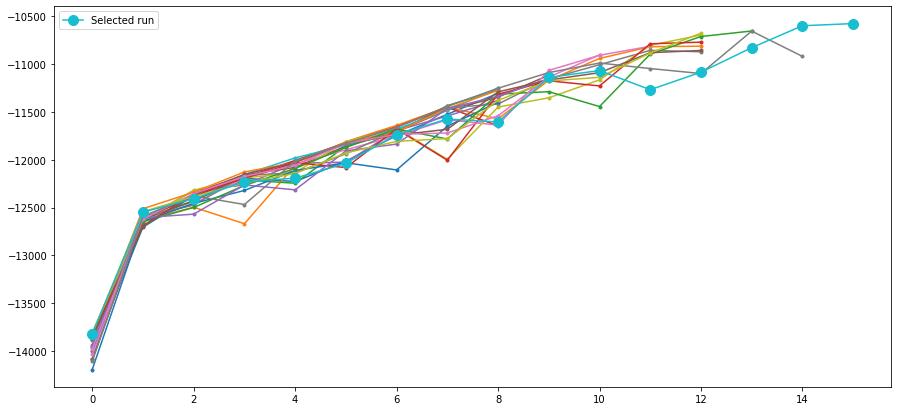

In [57]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): 
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [39]:
raykar_fx = R_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(raykar_fx, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(raykar_fx, X_test, Z_test))

Train accuracy of model = 0.9117823564712942
Test accuracy of model = 0.7334333583395849


## Reliability Annotator Model 

In [22]:
aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4200300   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           165120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 4,402,798
Trainable params: 202,498
Non-trainable params: 4,200,300
______________________________________

In [23]:
from codeE.methods import ModelInf_EM_R
LogReg_crowds = ModelInf_EM_R()

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
LogReg_crowds.set_model(aux_model, **args)

#LogReg_crowds.init_E(X_train, y_obs_categorical, method="softmv")
#LogReg_crowds.get_restimation()

logL_hists,i_r = LogReg_crowds.fit(X_train, y_obs_categorical, runs = 20, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
b shape:  (203, 1)
R estimate shape:  (4999, 203, 1)
Iter 1/50 
M step: done,  E step: done //  (in 1.72 sec)	logL: -17058.905	
Iter 2/50 
M step: done,  E step: done //  (in 0.66 sec)	logL: -15980.445	Tol1: 0.06322	Tol2: 0.00109	
Iter 3/50 
M step: done,  E step: done //  (in 0.68 sec)	logL: -15451.859	Tol1: 0.03308	Tol2: 0.00165	
Iter 4/50 
M step: done,  E step: done //  (in 0.65 sec)	logL: -15051.144	Tol1: 0.02593	Tol2: 0.00190	
Finished training
Initializing new EM...
b shape:  (203, 1)
R estimate shape:  (4999, 203, 1)
Iter 1/50 
M step: done,  E step: done //  (in 1.53 sec)	logL: -17034.645	
Iter 2/50 
M step: done,  E step: done //  (in 0.67 sec)	logL: -15982.595	Tol1: 0.06176	Tol2: 0.00116	
Iter 3/50 
M step: done,  E step: done //  (in 0.68 sec)	logL: -15564.066	Tol1: 0.02619	Tol2: 0.00168	
Finished training
Initializing new EM...
b shape:  (203, 1)
R estimate shape:  (4999, 203, 1)
Iter 1/50 
M step: done,  E step: done //  (in 1.55 sec)	logL: -18515.2

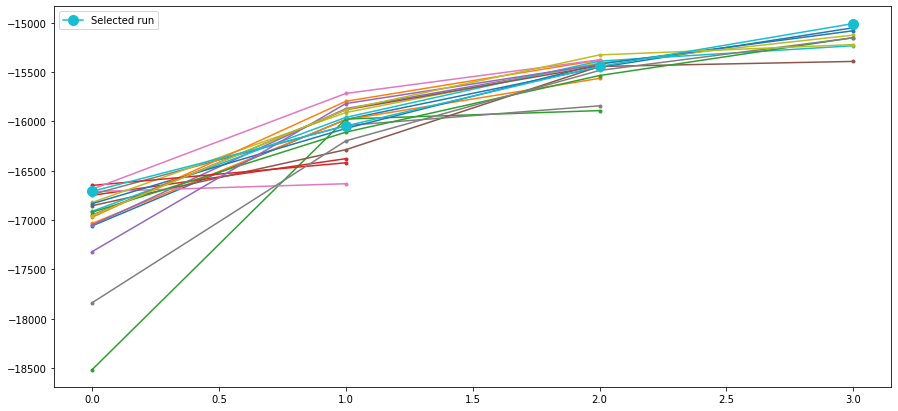

In [24]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): 
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [26]:
LogReg_fx = LogReg_crowds.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(LogReg_fx, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(LogReg_fx, X_test, Z_test))

Train accuracy of model = 0.795759151830366
Test accuracy of model = 0.7434358589647412


## C-MoA
Groups over individual scenario

#### Auxiliar representation with variable number of annotations per annotator and identity

In [44]:
y_cat_var, A_idx_var = set_representation(y_obs,"onehotvar")
print("Individual sparse representation, variable shape (N,)= ",y_cat_var.shape)
K = y_cat_var[0].shape[1]
print("one-hot vectors of K-dimensions, K=",K)
y_cat_var

Individual sparse representation, variable shape (N,)=  (4999,)
one-hot vectors of K-dimensions, K= 2


array([array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int8),
       array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int8),
       array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int8),
       ...,
       array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0]], dtype=int8),
       array([[0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]], dtype=int8),
       array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0]], dtype=int8)], dtype=object)

In [45]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4200300   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           165120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 4,402,798
Trainable params: 202,498
Non-trainable params: 4,200,300
______________________________________

#### Fixed annotators representation (non trainable embedding)

In [46]:
T= np.concatenate(A_idx_var).max() +1
A_rep = np.zeros((T, K))
for i in range(N):
    for l, t_idx in enumerate(A_idx_var[i]):
        obs_t = y_cat_var[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
print("shape of annotator representation (T, R_t)=", A_rep.shape)

shape of annotator representation (T, R_t)= (203, 2)


In [47]:
from keras.models import Sequential
from keras.layers import *
group_model = Sequential()
group_model.add(Embedding(T, K,input_length=1, 
                         trainable=False,weights=[A_rep]))
#                         trainable=True))
group_model.add(Reshape([K]))
group_model.add(Dense(K*M_seted, activation='relu'))
group_model.add(Dense(M_seted, activation='softmax'))
group_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 2)              406       
_________________________________________________________________
reshape_1 (Reshape)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
Total params: 445
Trainable params: 39
Non-trainable params: 406
_________________________________________________________________


In [48]:
from codeE.methods import ModelInf_EM_CMOA as CMOA
CMOA_model = CMOA(M=M_seted) 
#CMOA_model = CMOA(M=M_seted, init_Z='softmv', n_init_Z=0, n_init_G=0, priors=1) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMOA_model.set_model(aux_model, ann_model=group_model, **args)
#CMOA_model.set_model(group_model) #you also can set it manually

# if you want you can initialize step E forcing some method
#CMOA_model.init_E(y_cat_var, A_idx_var, method="hardmv")
#CMOA_model.get_qestimation()

CMOA_model.fit(X_train, y_cat_var, A_idx_var, runs = 20,max_iter=EPOCHS_BASE,tolerance=TOL) 

Initializing new EM...
Doing clustering...Done!
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.24 sec)	logL: -17625.454	
Iter 2/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -16747.986	Tol1: 0.04978	Tol2: 0.09618	
Iter 3/50
M step: done,  E step: done //  (in 0.74 sec)	logL: -15980.623	Tol1: 0.04582	Tol2: 0.08676	
Iter 4/50
M step: done,  E step: done //  (in 0.75 sec)	logL: -15282.435	Tol1: 0.04369	Tol2: 0.09088	
Iter 5/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -14951.506	Tol1: 0.02165	Tol2: 0.07884	
Iter 6/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -14578.729	Tol1: 0.02493	Tol2: 0.10473	
Iter 7/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -14734.526	Tol1: 0.01069	Tol2: 0.08248	
Iter 8/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -14090.047	Tol1: 0.04374	Tol2: 0.19222	
Iter 9/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -13746.264	Tol1: 0.02440	Tol2: 0.10038	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.72 sec)	logL: -11654.436	Tol1: 0.01085	Tol2: 0.13350	
Iter 21/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -11553.435	Tol1: 0.00867	Tol2: 0.08282	
Iter 22/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -11912.737	Tol1: 0.03110	Tol2: 0.09541	
Iter 23/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -11405.271	Tol1: 0.04260	Tol2: 0.18199	
Iter 24/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -11405.509	Tol1: 0.00002	Tol2: 0.07088	
Iter 25/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -11256.247	Tol1: 0.01309	Tol2: 0.10086	
Iter 26/50
M step: done,  E step: done //  (in 0.74 sec)	logL: -11180.766	Tol1: 0.00671	Tol2: 0.10009	
Iter 27/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -11061.641	Tol1: 0.01065	Tol2: 0.07095	
Iter 28/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -11105.093	Tol1: 0.00393	Tol2: 0.08614	
Iter 29/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -11166.838	Tol1: 0.00

M step: done,  E step: done //  (in 0.71 sec)	logL: -10921.773	Tol1: 0.03559	Tol2: 0.20722	
Iter 27/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10748.733	Tol1: 0.01584	Tol2: 0.09608	
Iter 28/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -10644.052	Tol1: 0.00974	Tol2: 0.07983	
Iter 29/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10675.602	Tol1: 0.00296	Tol2: 0.06825	
Iter 30/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -10555.720	Tol1: 0.01123	Tol2: 0.07263	
Iter 31/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10472.851	Tol1: 0.00785	Tol2: 0.09419	
Iter 32/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10488.570	Tol1: 0.00150	Tol2: 0.09551	
Iter 33/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -10541.656	Tol1: 0.00506	Tol2: 0.06545	
Iter 34/50
M step: done,  E step: done //  (in 0.73 sec)	logL: -10465.070	Tol1: 0.00727	Tol2: 0.07510	
Iter 35/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -10410.690	Tol1: 0.00

M step: done,  E step: done //  (in 0.70 sec)	logL: -10514.895	Tol1: 0.00936	Tol2: 0.08922	
Iter 37/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -10593.756	Tol1: 0.00750	Tol2: 0.05178	
Iter 38/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10502.738	Tol1: 0.00859	Tol2: 0.07326	
Iter 39/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -10508.689	Tol1: 0.00057	Tol2: 0.07118	
Iter 40/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -10449.473	Tol1: 0.00563	Tol2: 0.05546	
Iter 41/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10423.369	Tol1: 0.00250	Tol2: 0.07132	
Iter 42/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -10442.559	Tol1: 0.00184	Tol2: 0.05270	
Iter 43/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10369.557	Tol1: 0.00699	Tol2: 0.04468	
Iter 44/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -10342.028	Tol1: 0.00265	Tol2: 0.06391	
Iter 45/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10304.318	Tol1: 0.00

M step: done,  E step: done //  (in 0.71 sec)	logL: -10914.803	Tol1: 0.00787	Tol2: 0.05506	
Iter 31/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10994.960	Tol1: 0.00734	Tol2: 0.07503	
Iter 32/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -11037.262	Tol1: 0.00385	Tol2: 0.09897	
Iter 33/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10819.825	Tol1: 0.01970	Tol2: 0.09698	
Iter 34/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10783.912	Tol1: 0.00332	Tol2: 0.05872	
Iter 35/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -10728.285	Tol1: 0.00516	Tol2: 0.04840	
Iter 36/50
M step: done,  E step: done //  (in 0.74 sec)	logL: -10678.789	Tol1: 0.00461	Tol2: 0.06373	
Iter 37/50
M step: done,  E step: done //  (in 0.74 sec)	logL: -10685.184	Tol1: 0.00060	Tol2: 0.06413	
Iter 38/50
M step: done,  E step: done //  (in 0.77 sec)	logL: -10591.921	Tol1: 0.00873	Tol2: 0.07616	
Iter 39/50
M step: done,  E step: done //  (in 0.78 sec)	logL: -10551.089	Tol1: 0.00

M step: done,  E step: done //  (in 0.75 sec)	logL: -10609.795	Tol1: 0.00940	Tol2: 0.08149	
Iter 37/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -10586.639	Tol1: 0.00218	Tol2: 0.03998	
Iter 38/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -10612.661	Tol1: 0.00246	Tol2: 0.05109	
Iter 39/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -10826.019	Tol1: 0.02010	Tol2: 0.06788	
Iter 40/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -10519.411	Tol1: 0.02832	Tol2: 0.15277	
Iter 41/50
M step: done,  E step: done //  (in 0.73 sec)	logL: -10438.893	Tol1: 0.00765	Tol2: 0.05857	
Iter 42/50
M step: done,  E step: done //  (in 0.74 sec)	logL: -10434.419	Tol1: 0.00043	Tol2: 0.05205	
Iter 43/50
M step: done,  E step: done //  (in 0.73 sec)	logL: -10530.786	Tol1: 0.00924	Tol2: 0.06212	
Iter 44/50
M step: done,  E step: done //  (in 0.76 sec)	logL: -10352.334	Tol1: 0.01695	Tol2: 0.10740	
Iter 45/50
M step: done,  E step: done //  (in 0.74 sec)	logL: -10331.699	Tol1: 0.00

([array([-17625.4541, -16747.9864, -15980.623 , -15282.4352, -14951.5064,
         -14578.7287, -14734.5259, -14090.0473, -13746.2639, -13756.8577,
         -13291.5975, -12863.333 , -12594.4729, -12305.9739, -12189.4311,
         -11902.6715, -11762.3206, -11613.7582, -11469.3497, -11359.8515,
         -11422.5503, -11418.3668, -11262.3341, -11080.0989, -10988.2448,
         -10938.6245, -10888.8913, -10872.9948]),
  array([-17661.371 , -16756.0176, -16253.6821, -15578.6273, -15100.7578,
         -14729.0524, -14373.769 , -14061.6267, -13983.7633, -13521.8135,
         -13481.4125]),
  array([-17840.8097, -16855.9405, -16297.6582, -15764.6711, -15267.7715,
         -14862.4884, -14571.509 , -14321.3563, -14120.821 , -13831.9365,
         -13397.6454, -13082.6896, -12767.2367, -13207.2546, -12405.8701,
         -12172.4767, -11932.8185, -11986.1839, -11697.0495, -11562.1895,
         -11854.1394, -11542.0218, -11628.7363, -11298.1075, -11231.3336,
         -11111.6337, -11036.8799, -11

In [49]:
cmoaK_fx = CMOA_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmoaK_fx, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmoaK_fx, X_test, Z_test))

Train accuracy of model = 0.8799759951990398
Test accuracy of model = 0.7516879219804952


## CMM
Groups over global scenario

In [40]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4200300   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           165120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 4,402,798
Trainable params: 202,498
Non-trainable params: 4,200,300
______________________________________

In [42]:
from codeE.methods import ModelInf_EM_CMM as  CMM
CMM_model = CMM(M=M_seted) 
#CMM_model = CMM(M=M_seted, init_Z='model', n_init_Z=5, priors=0) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMM_model.set_model(aux_model, **args)

# if you want you can initialize step E forcing some method
#CMM_model.init_E(r_obs, method="hardmv")
#CMM_model.get_qestimation()

CMM_model.fit(X_train, r_obs, runs =20,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 2, 2)
Q estimate:  (4999, 2, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 1.56 sec)	logL: -17139.525	
Iter 2/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -16413.043	Tol1: 0.04239	Tol2: 0.36478	Tol3: 0.03615	
Iter 3/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -15915.286	Tol1: 0.03033	Tol2: 0.05530	Tol3: 0.03928	
Iter 4/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -15518.041	Tol1: 0.02496	Tol2: 0.04897	Tol3: 0.03836	
Iter 5/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -15305.557	Tol1: 0.01369	Tol2: 0.04307	Tol3: 0.03388	
Iter 6/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -14829.171	Tol1: 0.03113	Tol2: 0.06378	Tol3: 0.05460	
Iter 7/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -14490.487	Tol1: 0.02284	Tol2: 0.03795	Tol3: 0.02270	
Iter 8/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -14189.173	Tol1: 0.02079	Tol2: 0.02935	Tol3: 0.02299	
Finis

M step: done,  E step: done //  (in 0.56 sec)	logL: -11243.501	Tol1: 0.00620	Tol2: 0.03718	Tol3: 0.02730	
Iter 28/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -11146.869	Tol1: 0.00859	Tol2: 0.03091	Tol3: 0.02531	
Iter 29/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -11077.563	Tol1: 0.00622	Tol2: 0.06106	Tol3: 0.03843	
Iter 30/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -11109.573	Tol1: 0.00289	Tol2: 0.04553	Tol3: 0.03432	
Iter 31/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -11055.644	Tol1: 0.00485	Tol2: 0.08814	Tol3: 0.05980	
Iter 32/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -11022.189	Tol1: 0.00303	Tol2: 0.06582	Tol3: 0.04320	
Iter 33/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -10983.236	Tol1: 0.00353	Tol2: 0.09198	Tol3: 0.06197	
Iter 34/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -10883.052	Tol1: 0.00912	Tol2: 0.04522	Tol3: 0.03320	
Iter 35/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -10960.165	T

M step: done,  E step: done //  (in 0.57 sec)	logL: -11825.482	Tol1: 0.02286	Tol2: 0.03109	Tol3: 0.02473	
Iter 19/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -11775.665	Tol1: 0.00421	Tol2: 0.02587	Tol3: 0.02085	
Finished training!
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 2, 2)
Q estimate:  (4999, 2, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -17528.521	
Iter 2/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -16827.209	Tol1: 0.04001	Tol2: 0.37511	Tol3: 0.05611	
Iter 3/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -16054.686	Tol1: 0.04591	Tol2: 0.07342	Tol3: 0.04770	
Iter 4/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -15483.371	Tol1: 0.03559	Tol2: 0.06369	Tol3: 0.04570	
Iter 5/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -15051.080	Tol1: 0.02792	Tol2: 0.05483	Tol3: 0.04535	
Iter 6/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -14786.085	Tol1: 0.01761	Tol2: 0.04861	Tol3: 0.04

([array([-17139.5248, -16413.0426, -15915.286 , -15518.0415, -15305.5574,
         -14829.1709, -14490.4869, -14189.1728]),
  array([-17348.2058, -16549.013 , -15904.9904, -15473.185 , -15124.5424,
         -14754.4647, -14514.0862, -14371.9895, -13962.571 , -13729.5137,
         -13274.1826, -13101.2028, -12833.0911, -12504.1941, -12497.2335,
         -12149.473 , -11960.1263, -12300.3441]),
  array([-17164.9199, -16708.7656, -15989.816 , -15544.0926, -15130.6887,
         -14776.5449, -14454.8589, -14085.4399, -13905.6935, -13617.3964,
         -13403.693 , -13054.986 , -12640.9199, -12729.6855]),
  array([-17206.0985, -16493.8015, -15841.4831, -15487.4828, -15030.9144,
         -14680.7012, -14622.6769, -14160.394 , -13828.7773, -13549.9885,
         -13290.1492, -13369.7713, -12673.9535, -12485.6521, -12264.7707,
         -12155.3323]),
  array([-17533.6603, -16701.9508, -16087.1613, -15607.9674, -15193.1844,
         -14982.3909, -14526.6434, -14346.0714, -14235.4353, -13691.4471,

In [43]:
cmm_fx = CMM_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmm_fx, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmm_fx, X_test, Z_test))

Train accuracy of model = 0.8857771554310863
Test accuracy of model = 0.7494373593398349


## Global Behavior - Label Noise
As CMM with *M=1*

In [16]:
aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4200300   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           165120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 4,402,798
Trainable params: 202,498
Non-trainable params: 4,200,300
______________________________________

In [18]:
from codeE.methods import ModelInf_EM_G as G_Noise
GNoise_model = G_Noise() 
#GNoise_model = G_Noise(init_Z='model', n_init_Z=5, priors=0) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
GNoise_model.set_model(aux_model, **args)

# if you want you can initialize step E forcing some method
#GNoise_model.init_E(r_obs, method="hardmv")
#GNoise_model.get_qestimation()

logL_hists,i_r = GNoise_model.fit(X_train, r_obs, runs =20,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Beta:  (2, 2)
Q estimate:  (4999, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.58 sec)	logL: -15471.541	
Iter 2/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -14804.922	Tol1: 0.04309	Tol2: 0.14822	
Iter 3/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -14445.659	Tol1: 0.02427	Tol2: 0.05170	
Iter 4/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -14291.207	Tol1: 0.01069	Tol2: 0.00385	
Finished training!
Initializing new EM...
Beta:  (2, 2)
Q estimate:  (4999, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.17 sec)	logL: -15563.266	
Iter 2/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -14679.100	Tol1: 0.05681	Tol2: 0.14399	
Iter 3/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -14816.685	Tol1: 0.00937	Tol2: 0.02538	
Finished training!
Initializing new EM...
Beta:  (2, 2)
Q estimate:  (4999, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.15 sec)	logL: -15457.817	
Iter 2/50
M step: done,  E step: done //  (in 0.63

Initializing new EM...
Beta:  (2, 2)
Q estimate:  (4999, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.19 sec)	logL: -15465.021	
Iter 2/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -14793.723	Tol1: 0.04341	Tol2: 0.14837	
Iter 3/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -14552.440	Tol1: 0.01631	Tol2: 0.02653	
Finished training!
Initializing new EM...
Beta:  (2, 2)
Q estimate:  (4999, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.21 sec)	logL: -15424.634	
Iter 2/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -14670.667	Tol1: 0.04888	Tol2: 0.14491	
Iter 3/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -14616.854	Tol1: 0.00367	Tol2: 0.02866	
Finished training!
Initializing new EM...
Beta:  (2, 2)
Q estimate:  (4999, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.23 sec)	logL: -15335.066	
Iter 2/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -15036.240	Tol1: 0.01949	Tol2: 0.14577	
Iter 3/50
M step: done,  E step: done //  (in 0.65

In [19]:
G_fx = GNoise_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(G_fx, X_train, Z_train))
print("Test accuracy of model =", accuracy_model(G_fx, X_test, Z_test))

Train accuracy of model = 0.8409681936387278
Test accuracy of model = 0.7514378594648662


## Confusion Matrices Visualization

In [62]:
from codeE.utils import generate_confusionM
from codeE.utils import plot_confusion_matrix, compare_conf_ma, compare_set_conf_ma
from codeE.evaluation import Individual_D, D_JS, D_NormF

> ### Global scenario

#### MV

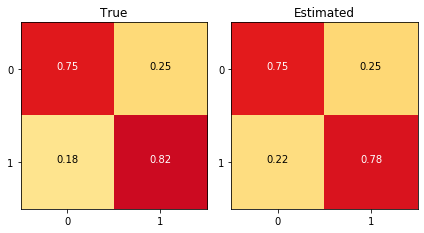

Global D (based on Jensen Shannon) = 0.001091619232014267
Global D (based on normalized Frobenius) = 0.031010834500193596


In [51]:
### SOFT
prob_Yz = generate_confusionM(mv_soft, r_obs) #confusion matrix of all annotations
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

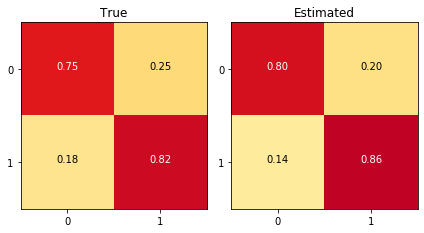

Global D (based on Jensen Shannon) = 0.0018885730640643085
Global D (based on normalized Frobenius) = 0.03987046331167221


In [52]:
### HARD
prob_Yz = generate_confusionM(mv_hard, r_obs) 
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### CMM

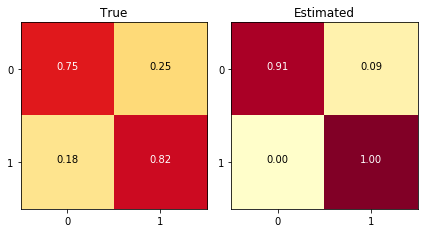

Global D (based on Jensen Shannon) = 0.05722243437245026
Global D (based on normalized Frobenius) = 0.16409692932287706


In [53]:
prob_Yz = CMM_model.get_global_confusionM()

compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### Global - Label Noise (without predictive model)

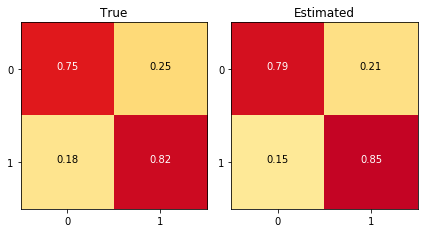

Global D (based on Jensen Shannon) = 0.0012072251637555709
Global D (based on normalized Frobenius) = 0.032839953899383545


In [69]:
prob_Yz = LabG_Noise_model.get_global_confusionM()
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### Global - Label Noise (with predictive model)

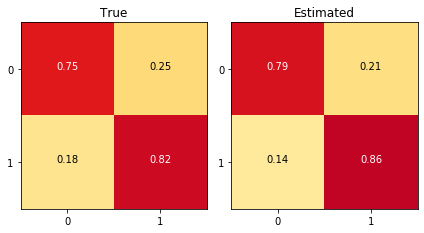

Global D (based on Jensen Shannon) = 0.0012716128481904097
Global D (based on normalized Frobenius) = 0.032570142298936844


In [21]:
prob_Yz = GNoise_model.get_global_confusionM()
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

>### Individual scenario

#### DS

Plot 5 random matrices from the set


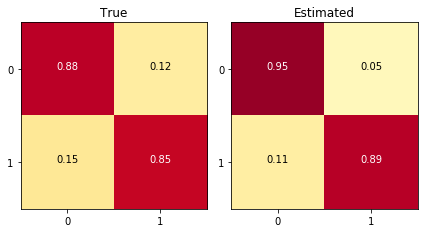

D (based on Jensen Shannon) = 0.007928023320919486
D (based on normalized Frobenius) = 0.05979391932487488


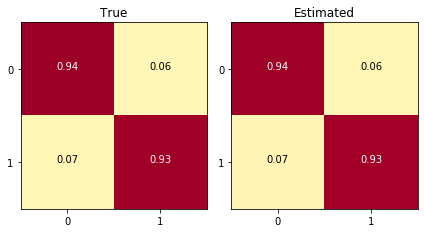

D (based on Jensen Shannon) = 3.820828041929696e-05
D (based on normalized Frobenius) = 0.003704364877194166


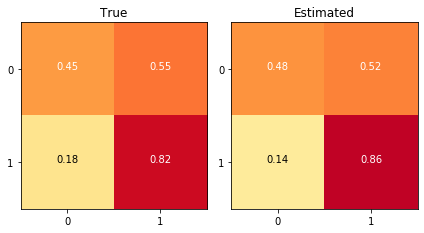

D (based on Jensen Shannon) = 0.001264197104082796
D (based on normalized Frobenius) = 0.0332149937748909


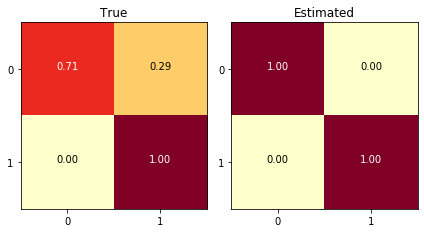

D (based on Jensen Shannon) = 0.07904647250908188
D (based on normalized Frobenius) = 0.20174914598464966


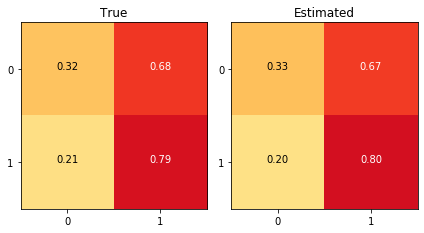

D (based on Jensen Shannon) = 7.610551409113501e-05
D (based on normalized Frobenius) = 0.00894396472722292


In [54]:
prob_Yzt = DS_model.get_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [55]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.020501345468101718
Individual D_NormF =  0.07443660041759495


#### Raykar

Plot 5 random matrices from the set


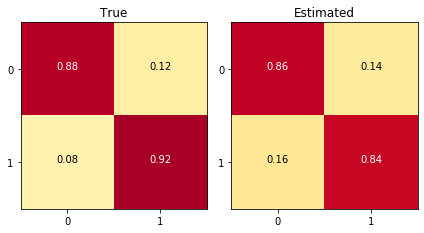

D (based on Jensen Shannon) = 0.004903300954412042
D (based on normalized Frobenius) = 0.05347186326980591


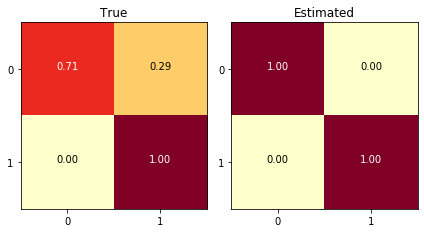

D (based on Jensen Shannon) = 0.0800556882021762
D (based on normalized Frobenius) = 0.2020305097103119


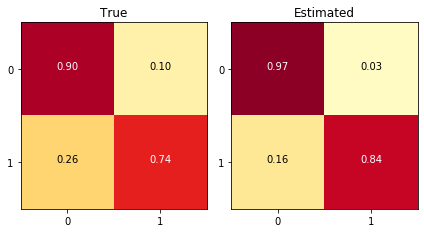

D (based on Jensen Shannon) = 0.013482437491257137
D (based on normalized Frobenius) = 0.08998911827802658


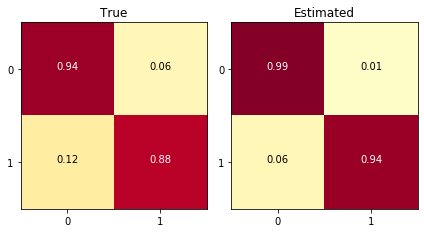

D (based on Jensen Shannon) = 0.01138416853386328
D (based on normalized Frobenius) = 0.056896161288022995


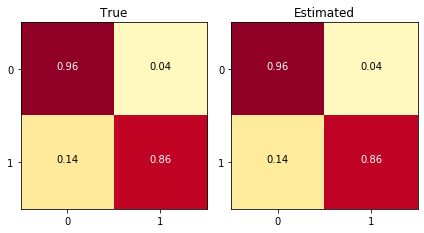

D (based on Jensen Shannon) = 2.4903886140869635e-05
D (based on normalized Frobenius) = 0.004070466384291649


In [56]:
prob_Yzt = R_model.get_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [57]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.023342278372848514
Individual D_NormF =  0.07746179691822985


#### C-MoA

Plot 5 random matrices from the set


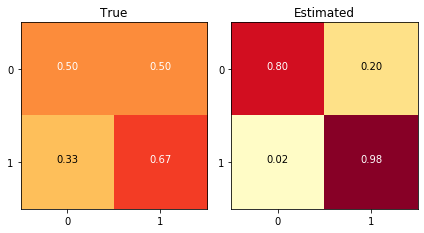

D (based on Jensen Shannon) = 0.10963026645604498
D (based on normalized Frobenius) = 0.30845511827376915


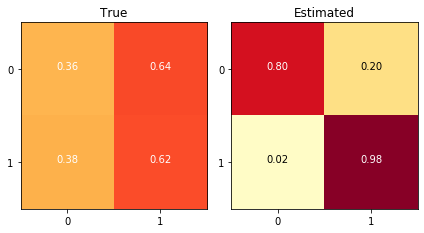

D (based on Jensen Shannon) = 0.15677884577100173
D (based on normalized Frobenius) = 0.3956671896014532


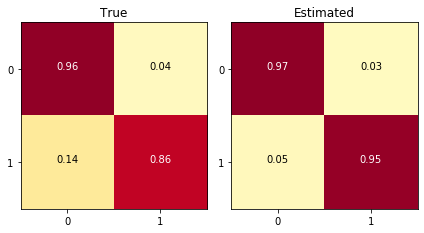

D (based on Jensen Shannon) = 0.01012296733783246
D (based on normalized Frobenius) = 0.06791736183155961


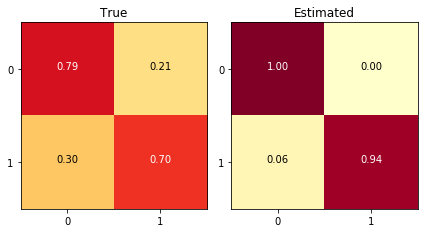

D (based on Jensen Shannon) = 0.0930999525758121
D (based on normalized Frobenius) = 0.22539713550125665


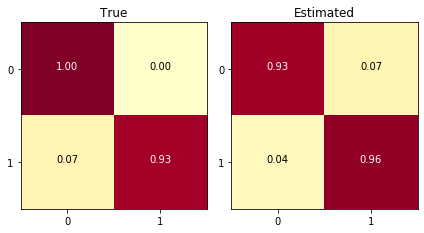

D (based on Jensen Shannon) = 0.019432817111342624
D (based on normalized Frobenius) = 0.0536721610702688


In [58]:
A = np.unique(np.concatenate(A_idx_var)).reshape(-1,1)
prob_Yzt = CMOA_model.get_ann_confusionM(A) # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [59]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.08213268136578118
Individual D_NormF =  0.19953688467811037


#### Reliability

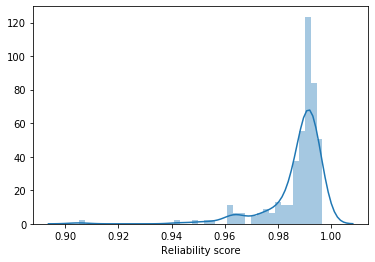

Mean score = 0.987019123150916
Maximum score = 0.9966951370239258
Minimum score = 0.9051119804382324


In [76]:
sns.distplot(LogReg_crowds.get_ann_rel().flatten())
plt.xlabel("Reliability score")
plt.show()

print("Mean score =", LogReg_crowds.get_ann_rel().mean())
print("Maximum score =", LogReg_crowds.get_ann_rel().max())
print("Minimum score =", LogReg_crowds.get_ann_rel().min())

### The behaviors of the groups found by CMM and CMOA

In [60]:
from codeE.evaluation import I_sim, R_score, H_conf, S_score, S_bias

**For CMM**
Group  1


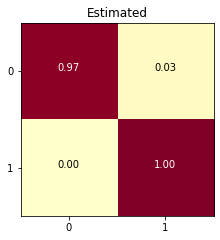

Expertise Identity (I_sim) = 0.9929995516330097
Expertise Diagonal (R_score) = 0.9861376691360852
Randomness (H_conf) = 0.09172793802944372
Spammer score (S_score) = 0.9722753382721707
Bias for class index 1 with score = 0.013804
-------------------------------------------------
Group  2


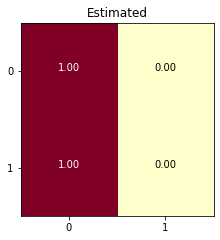

Expertise Identity (I_sim) = 0.5010092213300428
Expertise Diagonal (R_score) = 0.500153826540473
Randomness (H_conf) = 0.0020184997012979533
Spammer score (S_score) = 0.00030765308094613295
Bias for class index 0 with score = 0.499846
-------------------------------------------------
Group  3


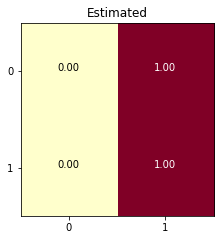

Expertise Identity (I_sim) = 0.5000041940002948
Expertise Diagonal (R_score) = 0.5000002635989863
Randomness (H_conf) = 8.660368989689335e-06
Spammer score (S_score) = 5.271979727242487e-07
Bias for class index 1 with score = 0.500000
-------------------------------------------------


In [61]:
print("**For CMM**")

B = CMM_model.get_confusionM()

for i, b in enumerate(B):
    print("Group ",(i+1))
    compare_conf_ma(b, text=True)

    print("Expertise Identity (I_sim) =", I_sim(b))
    print("Expertise Diagonal (R_score) =", R_score(b))
    print("Randomness (H_conf) =", H_conf(b))
    print("Spammer score (S_score) =", S_score(b))
    print("Bias for class index %d with score = %f"%(S_bias(b)))
    print("-------------------------------------------------")

**For C-MoA**
Group  1


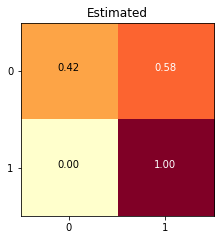

Expertise Identity (I_sim) = 0.8111032897771429
Expertise Diagonal (R_score) = 0.710064045387271
Randomness (H_conf) = 0.49235854488865377
Spammer score (S_score) = 0.4201280907745419
Bias for class index 1 with score = 0.289707
-------------------------------------------------
Group  2


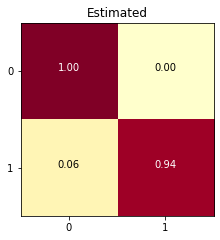

Expertise Identity (I_sim) = 0.9837356457797797
Expertise Diagonal (R_score) = 0.96821294829132
Randomness (H_conf) = 0.1725189041405809
Spammer score (S_score) = 0.9364258965826399
Bias for class index 0 with score = 0.031383
-------------------------------------------------
Group  3


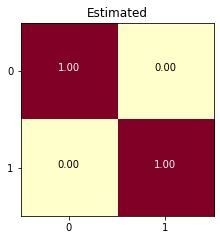

Expertise Identity (I_sim) = 0.9999971000767902
Expertise Diagonal (R_score) = 0.9999935607685154
Randomness (H_conf) = 0.00011997170394597606
Spammer score (S_score) = 0.9999871215370308
Bias for class index 1 with score = 0.000002
-------------------------------------------------


In [62]:
print("**For C-MoA**")

B = CMOA_model.get_confusionM()

for i, b in enumerate(B):
    print("Group ",(i+1))
    compare_conf_ma(b, text=True)

    print("Expertise Identity (I_sim) =", I_sim(b))
    print("Expertise Diagonal (R_score) =", R_score(b))
    print("Randomness (H_conf) =", H_conf(b))
    print("Spammer score (S_score) =", S_score(b))
    print("Bias for class index %d with score = %f"%(S_bias(b)))
    print("-------------------------------------------------")